EJERCICIO 6  

Crea un set de datos de consultas (más de 300 preguntas en total) y categorizalas entre la 
fuente  de  datos  que  pueda  llegar  a  responder  esa  pregunta  entre  estadísticas, 
información y relaciones. 
 
Por ejemplo: 
-  ¿Cómo gano en el ajedrez? -> Información 
-  ¿Quién trabajó para el ta-te-ti? -> Relaciones 
-  ¿Qué puntaje tienen las damas? -> Estadística 
 
A continuación, transforma esas consultas en vectores y entrena un modelo de clasificación 
(a  gusto  del  estudiante)  en  donde  pueda  predecir  la categoría a través de la consulta 
ingresada. 
 
Agregar  métricas  y  análisis  durante  todo  el  desarrollo,  trabaje  en  varios  modelos  y 
comparelos. 
 

In [1]:
import pandas as pd

In [2]:
#Abrimos el archivo CSV conteniendo las preguntas
df = pd.read_csv('dataset_preguntas.csv')

In [3]:
df.head()

,pregunta,etiqueta
0,¿Qué empresa diseñó el empaque del juego?,relaciones
1,¿Qué celebridades han jugado Sagrada?,relaciones
2,¿Qué porcentaje de jugadores recomiendan Sagrada?,estadisticas
3,¿Qué puesto ocupa Sagrada en el ranking global...,estadisticas
4,¿Quién ganó el torneo nacional de Sagrada en 2...,relaciones


In [4]:
# Vamos a utilizar un modelo preentrenado de embeddings que soporte múltiples idiomas
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

/home/pedro/Repositories/NLP-TP1-P2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-25 22:26:38.710243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-25 22:26:38.780438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-25 22:26:39.999099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
#Generamos los embeddings de las preguntas
embeddings = embedding_model.encode(sentences=df['pregunta'].tolist(), show_progress_bar=True, convert_to_tensor=True).cpu().numpy()

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


In [6]:
# Guardamos las etiquetas codificadas
y = df['etiqueta']
y = y.astype('category').cat.codes

In [55]:
clases = {0: "estadisticas", 1: "informacion", 2: "relaciones"}

In [7]:
#Codificamos las etiquetas para poder utilizarlas en el modelo
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=3)

In [8]:
from sklearn.model_selection import train_test_split
# Dividimos el dataset en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, random_state=42
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# Definimos la arquitectura de la red neuronal
model = Sequential(
    [
        Input(shape=(768,)),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),  # 3 clases: piedra, papel, tijeras
    ]
)

2025-05-25 22:27:34.334481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-25 22:27:34.349420: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
# Compilamos el modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
# Usamos early stopping para frenar el entrenamiento
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")

In [15]:
# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    callbacks=[early_stopping],
    batch_size=32,
)

Epoch 1/200
10/10 [==============================] - 1s 23ms/step - loss: 1.0134 - accuracy: 0.5594 - val_loss: 0.8621 - val_accuracy: 0.8125
Epoch 2/200
10/10 [==============================] - 0s 5ms/step - loss: 0.7170 - accuracy: 0.8469 - val_loss: 0.5231 - val_accuracy: 0.8500
Epoch 3/200
10/10 [==============================] - 0s 5ms/step - loss: 0.3545 - accuracy: 0.9344 - val_loss: 0.2528 - val_accuracy: 0.9250
Epoch 4/200
10/10 [==============================] - 0s 5ms/step - loss: 0.1576 - accuracy: 0.9625 - val_loss: 0.1210 - val_accuracy: 0.9750
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0740 - accuracy: 0.9750 - val_loss: 0.0660 - val_accuracy: 0.9875
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0427 - accuracy: 0.9906 - val_loss: 0.0488 - val_accuracy: 0.9875
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.0265 - val_accuracy: 0.9875
Epoch 8/200


In [60]:
import numpy as np
import matplotlib.pyplot as plt

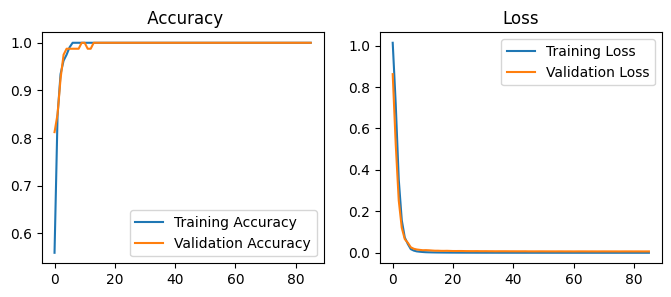

In [62]:
# Graficar pérdida de entrenamiento y validación
plt.figure(figsize=(8, 3))
epochs_range = range(len(history.history['loss']))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
    # Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(' Accuracy')
    # Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [63]:
pregunta = "Como se juega Sagrada?"

In [64]:
embedding_pregunta = embedding_model.encode(sentences=pregunta, show_progress_bar=True, convert_to_tensor=True).cpu().numpy()

Batches: 100%|██████████| 1/1 [00:00<00:00, 44.89it/s]


In [65]:
prediccion = model.predict(np.expand_dims(embedding_pregunta, axis=0))
clase_predicha = np.argmax(prediccion, axis=1)[0]

1/1 [==============================] - 0s 25ms/step


In [66]:
print(f"Clase predicha: {clases[clase_predicha]}")

Clase predicha: informacion
